In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt
import re
import string
from tqdm import tqdm
import time
from collections import Counter
import seaborn as sns
import gensim
from nltk.tokenize.treebank import TreebankWordDetokenizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras

import nltk
import torch
import spacy
from sklearn.preprocessing import binarize

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, Subset

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cpu



In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ss = pd.read_csv('sample_submission.csv')

train.dropna(inplace=True)

In [ ]:
print(train.shape)
print(test.shape)

(27480, 4)
(3534, 3)


In [ ]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


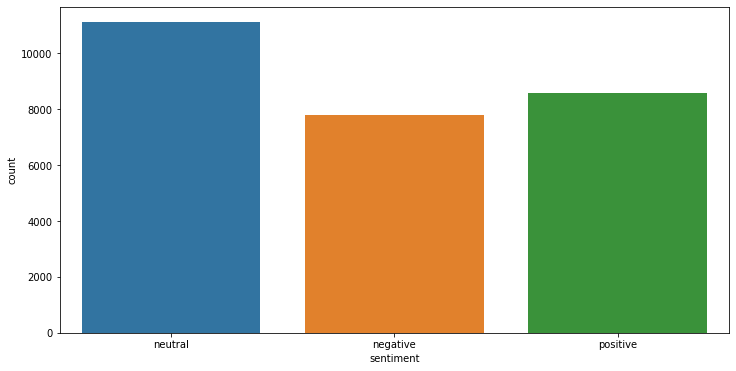

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    if (len(a) + len(b) - len(c)) == 0:
        return 0
    return float(len(c)) / (len(a) + len(b) - len(c))

def evaluate(true, pred):
    jac = 0
    for s1, s2 in zip(true, pred):
        jac += jaccard(s1, s2)
    jac /= len(true)
    return jac

In [ ]:
text = '2am feedings for the baby are fun when he is all smiles and coos'.split()
selected_text = '2am feedings for the baby are fun when he is all smiles and coos'.split()

print(text)
print(selected_text)
1*np.isin(text, selected_text).astype(int)

['2am', 'feedings', 'for', 'the', 'baby', 'are', 'fun', 'when', 'he', 'is', 'all', 'smiles', 'and', 'coos']
['2am', 'feedings', 'for', 'the', 'baby', 'are', 'fun', 'when', 'he', 'is', 'all', 'smiles', 'and', 'coos']


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
test.head()

,textID,text,sentiment,text_clean,selected_text_clean
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session of the day,
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,shanghai is also really exciting precisely sky...,
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho she has to ...,
3,01082688c6,happy bday!,positive,happy bday,
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,i like it,


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D, Dropout, SpatialDropout1D
#RNN
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model
#optimization
from tensorflow.keras.optimizers import Adam
#to calculate scores
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

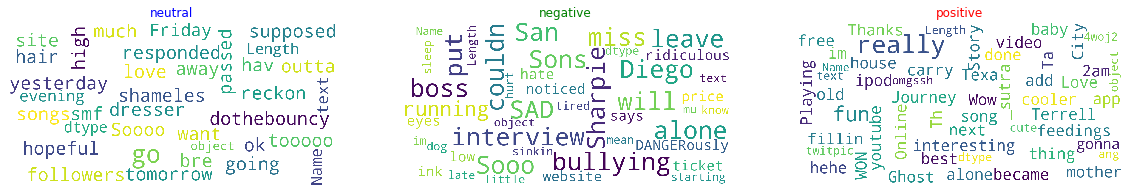

In [ ]:
df=pd.concat([train,test])
df['text']=df['text'].astype(str)
sent=df.sentiment.unique()
colors=['blue','green','red']
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None,ax=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1 
        )
    
    wordcloud=wordcloud.generate(str(data))
    ax.imshow(wordcloud,interpolation='nearest')
    ax.axis('off')

fig,ax=plt.subplots(1,3,figsize=(20,12))
for i in range(3):
      new=df[df['sentiment']==sent[i]]['text']
      show_wordcloud(new,ax=ax[i])
      ax[i].set_title(sent[i],color=colors[i])

In [ ]:
#Filling the null values if there are any
train["selected_text"].fillna("No content", inplace = True)

In [ ]:
'''Remove URLs from the tweets
Tokenize text
Remove emails
Remove new lines characters
Remove distracting single quotes
Remove all punctuation signs
Lowercase all text
Detokenize text
Convert list of texts to Numpy array'''

def depure_data(data):

    #URL/Link removal
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Emailremoval
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data


In [ ]:
temp = []
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,']

In [ ]:
# deacc=True removes punctuations
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


In [ ]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


In [ ]:
data = np.array(data)

In [ ]:
#Dataset is categorical
#convert the sentiment labels to a float type
#implementing to_categorical method from Keras.
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [ ]:
print(len(labels))

27475


In [ ]:
#implementing the Keras tokenizer 
#transform text data into 3D float data
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)

In [ ]:
print(tweets)
print(labels)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [ ]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20606 6869 20606 6869


In [ ]:
#LSTM model
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy',
               metrics=['accuracy'])
#Implementing model checkpoins to save the best metric 
#and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", 
                              monitor='val_accuracy', verbose=1,
                              save_best_only=True, mode='auto', period=1,
                              save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=70,
                     validation_data=(X_test, y_test),
                     callbacks=[checkpoint1])

Epoch 1/70
644/644 [==============================] - ETA: 0s - loss: 0.8205 - accuracy: 0.6262
Epoch 00001: val_accuracy improved from -inf to 0.73883, saving model to best_model1.hdf5
644/644 [==============================] - 56s 87ms/step - loss: 0.8205 - accuracy: 0.6262 - val_loss: 0.6980 - val_accuracy: 0.7388
Epoch 2/70
644/644 [==============================] - ETA: 0s - loss: 0.6121 - accuracy: 0.7566
Epoch 00002: val_accuracy improved from 0.73883 to 0.79007, saving model to best_model1.hdf5
644/644 [==============================] - 56s 87ms/step - loss: 0.6121 - accuracy: 0.7566 - val_loss: 0.5455 - val_accuracy: 0.7901
Epoch 3/70
644/644 [==============================] - ETA: 0s - loss: 0.5233 - accuracy: 0.7952
Epoch 00003: val_accuracy improved from 0.79007 to 0.79371, saving model to best_model1.hdf5
644/644 [==============================] - 55s 86ms/step - loss: 0.5233 - accuracy: 0.7952 - val_loss: 0.5021 - val_accuracy: 0.7937
Epoch 4/70
644/644 [=================

In [ ]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("best_model1.hdf5")

test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

215/215 - 3s - loss: 0.4335 - accuracy: 0.8452
Model accuracy:  0.8452467322349548
